In [2]:
import numpy as np
import joblib
import os
import cv2
from keras.models import save_model, load_model, Model
from keras.layers import Input, Dropout, BatchNormalization, LeakyReLU, concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
from imgaug import augmenters as iaa
from time import sleep
from sklearn.metrics import roc_curve, auc
from skimage import morphology

In [2]:
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1,1), padding='same'):
    x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x
 
def Conv2dT_BN(x, filters, kernel_size, strides=(2,2), padding='same'):
    x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x
 
inpt = Input(shape=(256, 256, 1))

conv1 = Conv2d_BN(inpt, 8, (3, 3))
conv1 = Conv2d_BN(conv1, 8, (3, 3))
pool1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(conv1)
 
conv2 = Conv2d_BN(pool1, 16, (3, 3))
conv2 = Conv2d_BN(conv2, 16, (3, 3))
pool2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(conv2)
 
conv3 = Conv2d_BN(pool2, 32, (3, 3))
conv3 = Conv2d_BN(conv3, 32, (3, 3))
pool3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(conv3)
 
conv4 = Conv2d_BN(pool3, 64, (3, 3))
conv4 = Conv2d_BN(conv4, 64, (3, 3))
pool4 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(conv4)
 
conv5 = Conv2d_BN(pool4, 128, (3, 3))
conv5 = Dropout(0.5)(conv5)
conv5 = Conv2d_BN(conv5, 128, (3, 3))
conv5 = Dropout(0.5)(conv5)
 
convt1 = Conv2dT_BN(conv5, 64, (3, 3))
concat1 = concatenate([conv4, convt1], axis=3)
concat1 = Dropout(0.5)(concat1)
conv6 = Conv2d_BN(concat1, 64, (3, 3))
conv6 = Conv2d_BN(conv6, 64, (3, 3))
 
convt2 = Conv2dT_BN(conv6, 32, (3, 3))
concat2 = concatenate([conv3, convt2], axis=3)
concat2 = Dropout(0.5)(concat2)
conv7 = Conv2d_BN(concat2, 32, (3, 3))
conv7 = Conv2d_BN(conv7, 32, (3, 3))
 
convt3 = Conv2dT_BN(conv7, 16, (3, 3))
concat3 = concatenate([conv2, convt3], axis=3)
concat3 = Dropout(0.5)(concat3)
conv8 = Conv2d_BN(concat3, 16, (3, 3))
conv8 = Conv2d_BN(conv8, 16, (3, 3))
 
convt4 = Conv2dT_BN(conv8, 8, (3, 3))
concat4 = concatenate([conv1, convt4], axis=3)
concat4 = Dropout(0.5)(concat4)
conv9 = Conv2d_BN(concat4, 8, (3, 3))
conv9 = Conv2d_BN(conv9, 8, (3, 3))
conv9 = Dropout(0.5)(conv9)
outpt = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), padding='same', activation='sigmoid')(conv9)

model = Model(inpt, outpt)

def metrics(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=[metrics])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# 训练集

sometimes = lambda aug: iaa.Sometimes(0.8, aug)

seq = iaa.Sequential(
    [
        sometimes(iaa.Crop(percent=(0, 0.1))), 
    
        sometimes(iaa.Affine(                          
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-20, 20),
            order=[0, 1],
            cval=(0, 255),
            mode="edge"
        )),
    ],
)

def metrics(y_true, y_pred):
    return 1 - K.mean(K.abs(y_true - y_pred))

model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=[metrics])

for t in range(100):
    root_path = "X-ray_Bone_Shadow_Supression_Split/augmented/augmented"
    img_folder = root_path + "/train/source"
    mask_folder = root_path + "/train/target"
    img_name = os.listdir(img_folder)
    mask_name = os.listdir(mask_folder)

    X = list()
    Y = list()
    for k in range(len(img_name)):
        if img_name[k].endswith(".png") and mask_name[k].endswith(".png"):
            img_path = img_folder + "/" + img_name[k]
            mask_path = mask_folder + "/" + mask_name[k]

            img = cv2.imread(img_path)
            img = cv2.resize(img, (256, 256))
            img = 255 - img
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            v = cv2.equalizeHist(v)
            hsv = cv2.merge((h, s, v))
            img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            img = img[:, :, 0].reshape(256, 256, 1)
            seq_det = seq.to_deterministic()
            img = seq_det.augment_image(img)
            img = img/255

            mask = cv2.imread(mask_path)
            mask = cv2.resize(mask, (256, 256))
            mask = 255 - mask
            hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            v = cv2.equalizeHist(v)
            hsv = cv2.merge((h, s, v))
            mask = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            mask = mask[:, :, 0].reshape(256, 256, 1)
            mask = seq_det.augment_image(mask)
            mask = mask/255

            X.append(img)
            Y.append(mask)
            
        if (k + 1)%64 == 0:
            X = np.array(X)
            Y = np.array(Y)
            model.fit(X, Y)
            X = list()
            Y = list()

    model.save("bone_unet_model/bone_unet_model_" + str(t) + ".h5")

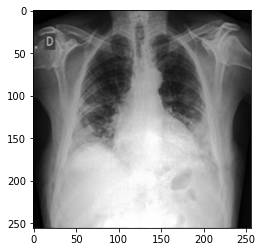

In [10]:
img = cv2.imread('COVID-19_Radiography_Dataset/COVID/images/COVID-6.png')
img = cv2.resize(img, (256, 256))
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
v = cv2.equalizeHist(v)
hsv = cv2.merge((h, s, v))
img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
img = img[:, :, 0].reshape(256, 256, 1)
img = img/255
plt.imshow(img, cmap="gray")

1/1 [==============================] - 1s 585ms/step


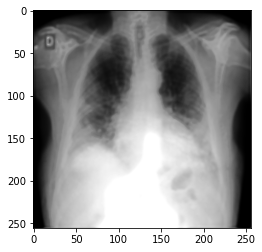

In [11]:
model = load_model('bone_unet_model/bone_unet_model_36.h5')
mask_pred = model.predict(img.reshape(1, 256, 256, 1)).reshape(256, 256, 1)
plt.imshow(mask_pred, cmap="gray")

In [59]:
# 测试集

model_folder = "bone_unet_model"
model_file = os.listdir(model_folder)

root_path = "X-ray_Bone_Shadow_Supression_Split/augmented/augmented"
img_folder = root_path + "/test/source"
mask_folder = root_path + "/test/target"
img_name = os.listdir(img_folder)
mask_name = os.listdir(mask_folder)
scores = np.empty(len(model_file))

X = list()
Y = list()

for k in range(len(img_name)):
    if img_name[k].endswith(".png") and mask_name[k].endswith(".png"):
        img_path = img_folder + "/" + img_name[k]
        mask_path = mask_folder + "/" + mask_name[k]

        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))
        img = 255 - img
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        v = cv2.equalizeHist(v)
        hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        img = img[:, :, 0].reshape(256, 256, 1)
        img = img/255

        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (256, 256))
        mask = 255 - mask
        hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        v = cv2.equalizeHist(v)
        hsv = cv2.merge((h, s, v))
        mask = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        mask = mask[:, :, 0].reshape(256, 256, 1)
        mask = mask/255
        
        X.append(img)
        Y.append(mask)

X = np.array(X)
Y = np.array(Y)

for t in range(len(model_file)):
    model = load_model(model_folder + '/' + model_file[t])
    Y_pred = model.predict(X)
    print(1 - np.mean(np.abs(Y - Y_pred)))
    scores[t] = 1 - np.mean(np.abs(Y - Y_pred))

15/15 [==============================] - 12s 774ms/step
0.8554858359091261
15/15 [==============================] - 12s 743ms/step
0.8636724193730312
15/15 [==============================] - 12s 770ms/step
0.9502359679904603
15/15 [==============================] - 12s 793ms/step
0.948187977606615
15/15 [==============================] - 12s 749ms/step
0.9517792216601303
15/15 [==============================] - 12s 775ms/step
0.9501106732623404
15/15 [==============================] - 12s 764ms/step
0.9531091622980993
15/15 [==============================] - 12s 793ms/step
0.9492102310619572
15/15 [==============================] - 12s 789ms/step
0.9543555560744187
15/15 [==============================] - 12s 752ms/step
0.9496301998620486
15/15 [==============================] - 12s 775ms/step
0.9501814064264711
15/15 [==============================] - 12s 751ms/step
0.9541441376309434
15/15 [==============================] - 12s 777ms/step
0.9076308425318804
15/15 [===================

36 0.9555083550876179


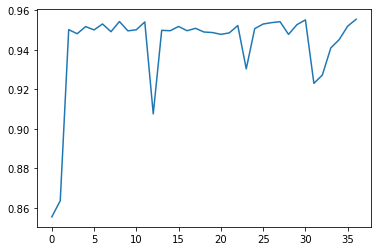

In [61]:
print(scores.argmax(), scores.max())
plt.plot(np.arange(len(model_file)), scores)
plt.show()